|||
|-|-|
|||
|||
|||
|||
|||
|||
|||

# Transfer Learning using PyTorch

In [1]:
!nvidia-smi

Thu Feb 19 06:46:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Important Libraries

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !rm -R /content/hymenoptera_data/train/.ipynb_checkpoints
# !ls /content/hymenoptera_data/test/train -a   #to make sure that the deletion has occurred

# !rm -R /content/hymenoptera_data/val/.ipynb_checkpoints
# !ls /content/hymenoptera_data/val -a   #to make sure that the deletion has occurred

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


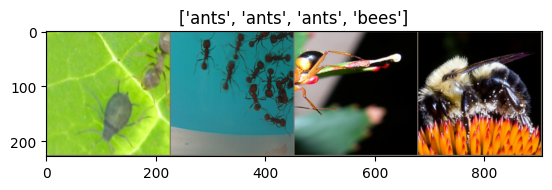

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


## Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6037 Acc: 0.6721
val Loss: 0.4605 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.6797 Acc: 0.7295
val Loss: 0.2455 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4325 Acc: 0.7992
val Loss: 0.2558 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4303 Acc: 0.8361
val Loss: 0.2352 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3384 Acc: 0.8402
val Loss: 0.2724 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4754 Acc: 0.8197
val Loss: 0.2611 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4721 Acc: 0.8033
val Loss: 0.3410 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3696 Acc: 0.8443
val Loss: 0.3100 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.2844 Acc: 0.8811
val Loss: 0.2904 Acc: 0.8627

Epoch 9/24
----------
train Loss: 0.2636 Acc: 0.9098
val Loss: 0.2930 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.3916 Acc: 0.8402
val Loss: 0.3125 Acc: 0.8562

Epoch 11/24
----------
train Loss: 0.2190 Acc: 0.9385
val Loss: 0.2928 Acc: 0.8889

Ep

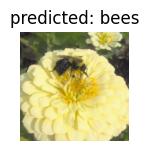

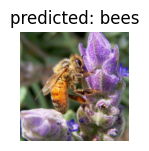

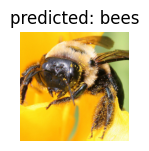

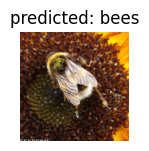

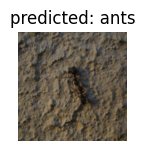

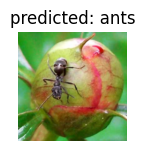

In [11]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6573 Acc: 0.6557
val Loss: 0.2217 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4638 Acc: 0.7992
val Loss: 0.1880 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3866 Acc: 0.8402
val Loss: 0.2299 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4944 Acc: 0.8238
val Loss: 0.2407 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3432 Acc: 0.8648
val Loss: 0.1679 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3750 Acc: 0.8320
val Loss: 0.2110 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5467 Acc: 0.7623
val Loss: 0.1921 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3551 Acc: 0.8525
val Loss: 0.1728 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2801 Acc: 0.8975
val Loss: 0.1784 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3209 Acc: 0.8607
val Loss: 0.1690 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3476 Acc: 0.8320
val Loss: 0.2032 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3754 Acc: 0.8074
val Loss: 0.2189 Acc: 0.9412

Ep

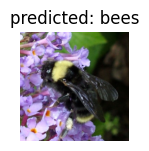

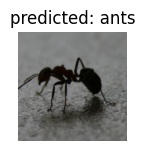

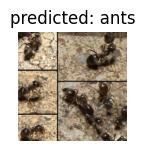

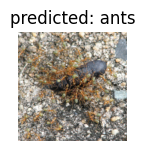

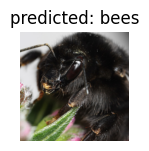

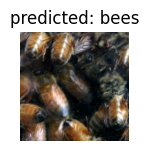

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

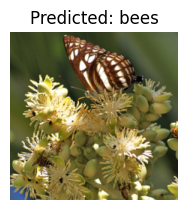

In [16]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/datasets/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout the
* [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).


# Supplementary Activity

In a new notebook, perform the following:
1. Choose a pretrained model.
2. Finetune on your dataset from the previous activity.
3. Evaluate the performance of the previous model to this finetuned model.
4. Utilize the pretrained ConvNet model as fixed feature extractor.
5. Evaluate the performance of the previous model to this finetuned model.
6.  Discuss the following:
  * How did finetuning affect your performance?
  * Which of the different situations for rule of thumb were applicable to you?

#### *1. Choose a pretrained model.*

In [17]:
model_sup = models.densenet169(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 215MB/s]


#### *2. Finetune on your dataset.*

***The dataset used was in the procedures so there is no need to load the data again, it is immediately on finetune and train.***

In [26]:
num_ftrs = model_sup.classifier.in_features
model_sup.classifier = nn.Linear(num_ftrs, 2)
model_sup = model_sup.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_sup.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### *3. Evaluate the performance of the previous model to this finetuned model*

In [27]:
model_sup = train_model(model_sup, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6716 Acc: 0.5533
val Loss: 0.5482 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5813 Acc: 0.7500
val Loss: 0.4391 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5023 Acc: 0.7828
val Loss: 0.3513 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4020 Acc: 0.8648
val Loss: 0.2952 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4805 Acc: 0.7459
val Loss: 0.2622 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3813 Acc: 0.8484
val Loss: 0.2425 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4106 Acc: 0.8238
val Loss: 0.2315 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3646 Acc: 0.8525
val Loss: 0.2311 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3637 Acc: 0.8770
val Loss: 0.2269 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3965 Acc: 0.8402
val Loss: 0.2170 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3838 Acc: 0.8402
val Loss: 0.2300 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4225 Acc: 0.8156
val Loss: 0.2261 Acc: 0.9477

Ep

in the output above, it can be seen that when compared to the previous model the densenet169 model performed with a validation accuracy of 0.96% as compared to the resnet18 performance of 0.90%. The validation accuracy even with using the same parameters for the tuning in the previous one also yielded the densenet169 model the same 0.96%. This means that the better model based on the data used is the densenet169. The reason for this can be seen behind their their network such that densenet169 has more layers while having fewer parameters such as some of them being reused in training, densenet requires more resources to train under it as well such that resnet18 is applicable on edge devices so the accuracy is traded off on it as compared to densenet169

#### *4. Utilize the pretrained ConvNet model as fixed feature extractor.*

In [24]:
model_sup = torchvision.models.densenet169(weights='IMAGENET1K_V1')
for param in model_sup.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_sup.classifier.in_features
model_sup.classifier = nn.Linear(num_ftrs, 2)

model_sup = model_sup.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_sup.classifier.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### *5. Evaluate the performance of the previous model to this finetuned model.*

In [25]:
model_sup = train_model(model_sup, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6511 Acc: 0.6393
val Loss: 0.5447 Acc: 0.7843

Epoch 1/24
----------
train Loss: 0.5480 Acc: 0.7623
val Loss: 0.4176 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5220 Acc: 0.7582
val Loss: 0.3699 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4799 Acc: 0.8033
val Loss: 0.3308 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4332 Acc: 0.8156
val Loss: 0.2769 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.4291 Acc: 0.8156
val Loss: 0.2763 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4336 Acc: 0.8033
val Loss: 0.2894 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3789 Acc: 0.8443
val Loss: 0.2563 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.4021 Acc: 0.8443
val Loss: 0.2719 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3908 Acc: 0.8730
val Loss: 0.2509 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3856 Acc: 0.8279
val Loss: 0.2427 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3791 Acc: 0.8648
val Loss: 0.2498 Acc: 0.9542

Ep

In the output above it can be seen that when compared to the two previous model under procedures which yielded both 0.90% and 0.95% validation accuracy and the supplementary model that yielded 0.96% validation accuracy, this latest model performed the best with the best validation accuracy of 0.9739 validation accuracy. This can be attributed to the changes made which is in parameters requiring it to be false, searching what does it mean for it to be a feature extraction it has said that this changes how it handles the pretrained model used. This says whether to use the dataset used in the pretrained model to train that model, by setting it to false it is saying that it will use the diverse dataset used to train the initial model to be the pretained model to be used to use that instead hence why it is the fixed feature extractor. Because it is using the diverse dataset, there are possibilities that depending on the dataset that will be used with it, it can yield either a high or low accuracy though in this case in yielded a high accuracy, higher.

#### 6. Discuss the following:
  * How did finetuning affect your performance?
  ***Finetuning affects it such that it will be the one that will decide how fit the data would be, how accurate it will be, how fast will it be trained. In my case, it helped in affecting in lowering my loss output as well as accuracy for both sets such that having a slightly lower learning rate compared to the initial tuning parameters used in the procedures yielded a great performance output immediately but being careful is needed for this as well since lowering it too much made it worse by it only around 0.70% accuracy instead with a high loss output.***
  * Which of the different situations for rule of thumb were applicable to you?
  ***For me the rule of thumbs that are applicable for me is the use of learning rate between 0.001 and 0.0001 only since while there are scenarios where a lower learning rate can be good, it only yielded a overfit model for me only. Additionally the rule of thumb of having a lower epoch is also applicable as well in this situation since having the proper combinations of tuning done yielded great results already in less time so adding too much epochs adds uncessary learning time and the possibility of overfitting as well.***